# [PhysiNet: A Combination of Physics-based Model and Neural Network Model for Digital Twins](https://arxiv.org/ftp/arxiv/papers/2106/2106.14790.pdf)

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# Plotting
import matplotlib.pyplot as plt
from PIL import Image

# Misc.
from pathlib import Path
import random as builtin_random
import numpy as np
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 41
builtin_random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 3.1.1 Experimental Setup and Comparative Models

To validate the effectiveness of PhysiNet, a dataset was generated as the ‘actual measurement data’. The
measurement dataset was generated by $y_i=ax_i^2 + b + \sigma$, in which 𝑎 = 0.1 , 𝑏 = 15 and 𝜎 is the noise 
generated by a normal distribution with 0.5 standard deviation. The physics-based model was assumed to be a 
linear model defined by $q_{physi}=cx_i + d$, in which 𝑐 = 1, 𝑑 = 10

In [2]:
a = 0.1
b = 15
sigma = 0.5
measure = lambda x: a * (x**2) + b + torch.normal(0, std=sigma, size=x.size()).to(x)

c = 1
d = 10
q_physi = lambda x: c * x + d

The neural network part of PhysiNet was built with 2 hidden layers having 10 neurons.

The weights for the neural network part were initialized randomly.

$w_{physi}$ and $w_{nn}$ were initialized as 0.99 and 0.01 respectively. 

In [3]:
class PhysiNet(nn.Module):
    def __init__(self, q_physi: callable, w_physi: float = 0.99, w_nn: float = 0.01):
        super().__init__()
        # In paper, activation type wasn't specified
        self.q_physi = q_physi
        self.q_nn = nn.Sequential(*(nn.Linear(1, 10), nn.ReLU(), nn.Linear(10, 1)))

        self.w_physi = nn.Parameter(torch.Tensor([w_physi]), requires_grad=True)
        self.w_nn = nn.Parameter(torch.Tensor([w_nn]), requires_grad=True)

    def forward(self, x):
        q_physi = self.q_physi(x)
        q_nn = self.q_nn(x)
        y_hat = self.w_physi * q_physi + self.w_nn * q_nn
        return y_hat

To simulate the digital-twin process, for each ‘time interval’ (batch), 80 points were ‘measured’ (actually, generated) 
from the ‘measurement data’ for each step. In each step, the 80 points were used to train the model for 40 epochs. 
In total, there are 100 steps in the training. 2000 points from ‘measurement data’ were used as the test dataset. 
The performance was evaluated by mean squared error (MSE)

In [4]:
time_interval = (0, 10)
batch_size = 80
total_steps = 100
train_epochs = 40

num_train_points = batch_size * total_steps  # 8_000
num_test_points = 2_000  # 2_000
num_total_points = num_train_points + num_test_points  # 10_000

criterion = torch.nn.MSELoss()

In [5]:
xs = torch.linspace(*time_interval, num_total_points)
measurement = measure(xs)
physics_prediction = q_physi(xs)

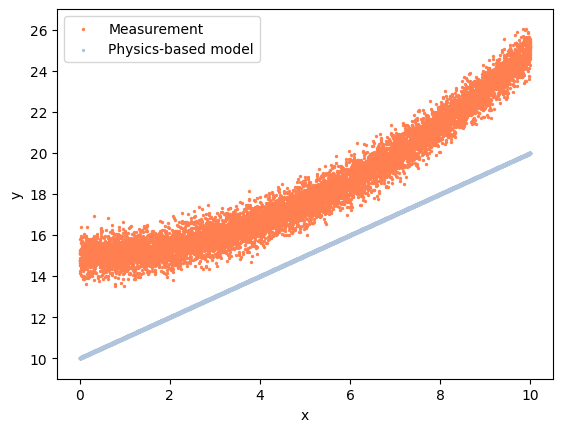

In [6]:
fig, ax = plt.subplots()
ax.scatter(xs, measurement, s=2, color="coral", label="Measurement")
ax.scatter(xs, physics_prediction, s=2, color="lightsteelblue", label="Physics-based model")
ax.update({"xlabel": "x", "ylabel": "y"})
ax.axis((-0.5, 10.5, 9, 27))
plt.legend()
plt.show()

In [8]:
# create train / test dataset
data = torch.Tensor(xs).view(-1, 1).to(device)
target = torch.Tensor(measurement).view(-1, 1).to(device)

dataset = TensorDataset(data, target)
trainset, testset = random_split(
    dataset=dataset,
    lengths=(num_train_points, num_test_points),
    generator=torch.Generator().manual_seed(42),
)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False)
test_loader = DataLoader(testset, batch_size=num_test_points, shuffle=False, pin_memory=False)

# learning rate is not specified
model = PhysiNet(q_physi, w_physi=0.99, w_nn=0.01).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


log_dir = Path("logs")
model_name = "PhysiNet"
model_log_dir = log_dir / model_name
img_dir = model_log_dir / "imgs"
img_dir.mkdir(parents=True, exist_ok=True)

w_physi_list = [model.w_physi.item()]
w_nn_list = [model.w_nn.item()]
steps_list = [-1]

for e in tqdm(range(train_epochs)):
    model.train()
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        optimizer.zero_grad()

        preds = model(train_x)
        loss = criterion(preds, train_y)
        loss.backward()
        optimizer.step()

        step = e * len(train_loader) + batch_idx
        if step % 10 == 0:
            # model.eval()
            with torch.no_grad():
                for test_x, test_y in test_loader:
                    inferred = model(test_x)
                    fig, ax = plt.subplots()
                    ax.scatter(
                        test_x.squeeze().detach().cpu(),
                        test_y.squeeze().detach().cpu(),
                        s=2,
                        color="coral",
                        label="Ground Truth",
                    )
                    ax.scatter(
                        test_x.squeeze().detach().cpu(),
                        inferred.squeeze().detach().cpu(),
                        s=2,
                        color="lightsteelblue",
                        label="PhysiNet Prediction",
                    )
                    ax.update({"xlabel": "x", "ylabel": "y"})
                    ax.set_title(
                        f"Step: {step}, "
                        + "$w_{physi}$: "
                        + f"{model.w_physi.item():.3f}, "
                        + "$w_{nn}$: "
                        + f"{model.w_nn.item():.3f}, "
                        + f"Loss: {criterion(inferred, test_y).item():.4f}",
                    )
                    ax.axis((-0.5, 10.5, 9, 27))
                    plt.legend()
                    plt.savefig((img_dir / f"step_{step:05d}").with_suffix(".png"))
                    plt.close("all")

                w_physi_list.append(model.w_physi.item())
                w_nn_list.append(model.w_nn.item())
                steps_list.append(step)

files = img_dir.glob("*.png")
imgs = [Image.open(file) for file in sorted(files)]
imgs[0].save(
    fp=(model_log_dir / f"{model_name} - implementation").with_suffix(".gif"),
    format="GIF",
    append_images=imgs[1:],
    save_all=True,
    duration=int(1000 / 20),
    loop=0,
)

w_physi = np.array(w_physi_list)
w_nn = np.array(w_nn_list)
steps = np.array(steps_list)
fig, ax = plt.subplots()
ax.plot(steps, w_physi / w_nn, label="Weight for Physics-based Model")
ax.update({"xlabel": "Steps", "ylabel": "Weight Ratio($w_{physi}/w_{nn}$)"})
plt.legend()
plt.savefig((model_log_dir / "Weight_Ratio").with_suffix(".png"))
plt.close("all")

  0%|          | 0/40 [00:00<?, ?it/s]